In [1]:
'''
Подключение всех нужных библиотек и функций
'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.decomposition import PCA
from IPython.display import display

In [2]:
# Начальное условие для генератора случайных чисел
np.random.seed(42)



'''
Процедура анализа данных
'''
def analyze(df, data_type, n_comps):
    # Вывод матрицы ковариаций
    def print_cov_matrix(X):
        # Вычисление матрицы ковариаций признаков
        def cov_matrix(X):
            return np.cov(X.T)

        cov_X = cov_matrix(X)
        s = 0
        
        for i in range(cov_X.shape[0]):
            s = s + cov_X[i][i]
        
        print('Выборочная матрица ковариаций:')
        print(cov_X)
        print('sum_var = ' + str(s))
        print()

    # Извлечение матрицы признаков из датафрейма
    def extract_X(df):
        features = df.columns[:-1]
        X = df.loc[:, features].values

        return X

    # Построение графика
    def graph(df, title, targets, elev = None, azim = None):
        # Эллипс рассеивания
        def draw_ellipse():
            u = v = 0
            a = (np.amax(PCA_X, axis=0)[0] - np.amin(PCA_X, axis=0)[0]) / 2
            b = (np.amax(PCA_X, axis=0)[1] - np.amin(PCA_X, axis=0)[1]) / 2
            t = (b / a) * np.pi / 4
            
            x_a = np.arange(0, a * np.cos(t), step=1e-2)
            y_a = t * x_a
            x_b = np.arange(0, b * np.sin(t), step=1e-1)
            y_b = (-1 / t) * x_b
            plt.plot(x_a, y_a, 'black')
            plt.plot(x_b, y_b, 'blue')
            
            alpha = np.linspace(0, 2 * np.pi, 100)
            Ell = np.array([a * np.cos(alpha), b * np.sin(alpha)])
            R_rot = np.array([
                    [np.cos(t), -np.sin(t)],
                    [np.sin(t), np.cos(t)]
                ])
            Ell_rot = np.zeros((2, Ell.shape[1]))
            
            for i in range(Ell.shape[1]):
                Ell_rot[:, i] = np.dot(R_rot, Ell[:, i])

            plt.plot(u + Ell_rot[0, :], v + Ell_rot[1, :], 'green')
        
        fig = plt.figure()
        
        if n_comps == 2:
            ax = fig.add_subplot(1, 1, 1)
        elif n_comps == 3:
            ax = fig.add_subplot(1, 1, 1, projection='3d')
            ax.set_zlabel(df.columns[2])
        
        ax.set_xlabel(df.columns[0])
        ax.set_ylabel(df.columns[1])
        ax.set_title(title)
        colors = ['r', 'g', 'b']

        for i in range(len(targets)):
            indicesToKeep = df[df.columns[-1]] == targets[i]

            if n_comps == 2:
                ax.scatter(df.loc[indicesToKeep, df.columns[0]],
                       df.loc[indicesToKeep, df.columns[1]],
                       c=colors[i])
            elif n_comps == 3:
                ax.scatter(df.loc[indicesToKeep, df.columns[0]],
                       df.loc[indicesToKeep, df.columns[1]],
                       df.loc[indicesToKeep, df.columns[2]],
                       c=colors[i])

        if data_type != 'model':
            if data_type == 'german':
                targets = [str(int(float(target))) + '-й класс' for target in targets]

            ax.legend(targets)

        if n_comps == 2:
            if data_type == 'model':
                draw_ellipse()
                
            ax.legend(['1-я главная компонента', '2-я главная компонента'])
            
        if data_type == 'german':
            ax.view_init(elev, azim)
            
        ax.grid()

    # Метод PCA
    def get_PCA_df(df, X):
        pca = PCA(n_components=n_comps)
        PCA_X = pca.fit_transform(X)
        
        cols = [str(i) + '-я главная компонента' for i in range(1, n_comps + 1)]
        principalDf = pd.DataFrame(
            data=PCA_X,
            columns=cols)
        class_name = df.columns[-1]
        finalDf = pd.concat([principalDf, df[class_name]], axis=1)

        return finalDf
    
    # Таблица кол-вом главных компонент и соответствующими % объясняемой информации
    def analyze_vars(X_orig):
        def discard(a, n):
            return ('{0:.' + str(n) + 'f}').format(a).rstrip('0').rstrip('.')
        
        table = pd.DataFrame(data=[], columns=['% объясняемой информации'])
        table.columns.name = 'Главных компонент'
        
        for comps in range(1, X_orig.shape[1] + 1):
            pca = PCA(n_components=comps)
            PCA_X = pca.fit_transform(X)
            table.loc[comps] = [np.sum(pca.explained_variance_ratio_) * 100]
            if comps == 3:
                print(pca.explained_variance_ratio_)
        display(table)

    print('*** Исходные данные ***\n\n')

    X = extract_X(df)
    print_cov_matrix(X)

    print('\n*** Данные после метода PCA ***\n\n')

    PCA_df = get_PCA_df(df, X)
    PCA_X = extract_X(PCA_df)
    print_cov_matrix(PCA_X)

    class_name = df.columns[-1]
    classes = np.unique(df.loc[:, class_name].values)
    
    if data_type == 'german':
        for azim in range(0, 360, 45):
            if n_comps <= 3:
                graph(PCA_df, 'График PCA-данных', classes, 45, azim)
                
        analyze_vars(X)
    elif n_comps <= 3:
        graph(PCA_df, 'График PCA-данных', classes)

<ipython-input-3-c17bb3abacd2>:11: RuntimeWarning: covariance is not positive-semidefinite.
  return np.random.multivariate_normal(mean=mean, cov=sigma, size=size)


*** Исходные данные ***


Выборочная матрица ковариаций:
[[2.27932356 2.44676781 2.61421206 2.78165631]
 [2.44676781 3.04387028 3.64097276 4.23807524]
 [2.61421206 3.64097276 4.66773347 5.69449418]
 [2.78165631 4.23807524 5.69449418 7.15091313]]
sum_var = 17.141840438702317


*** Данные после метода PCA ***


Выборочная матрица ковариаций:
[[1.59489160e+01 5.40553032e-16]
 [5.40553032e-16 1.19292439e+00]]
sum_var = 17.141840438702317



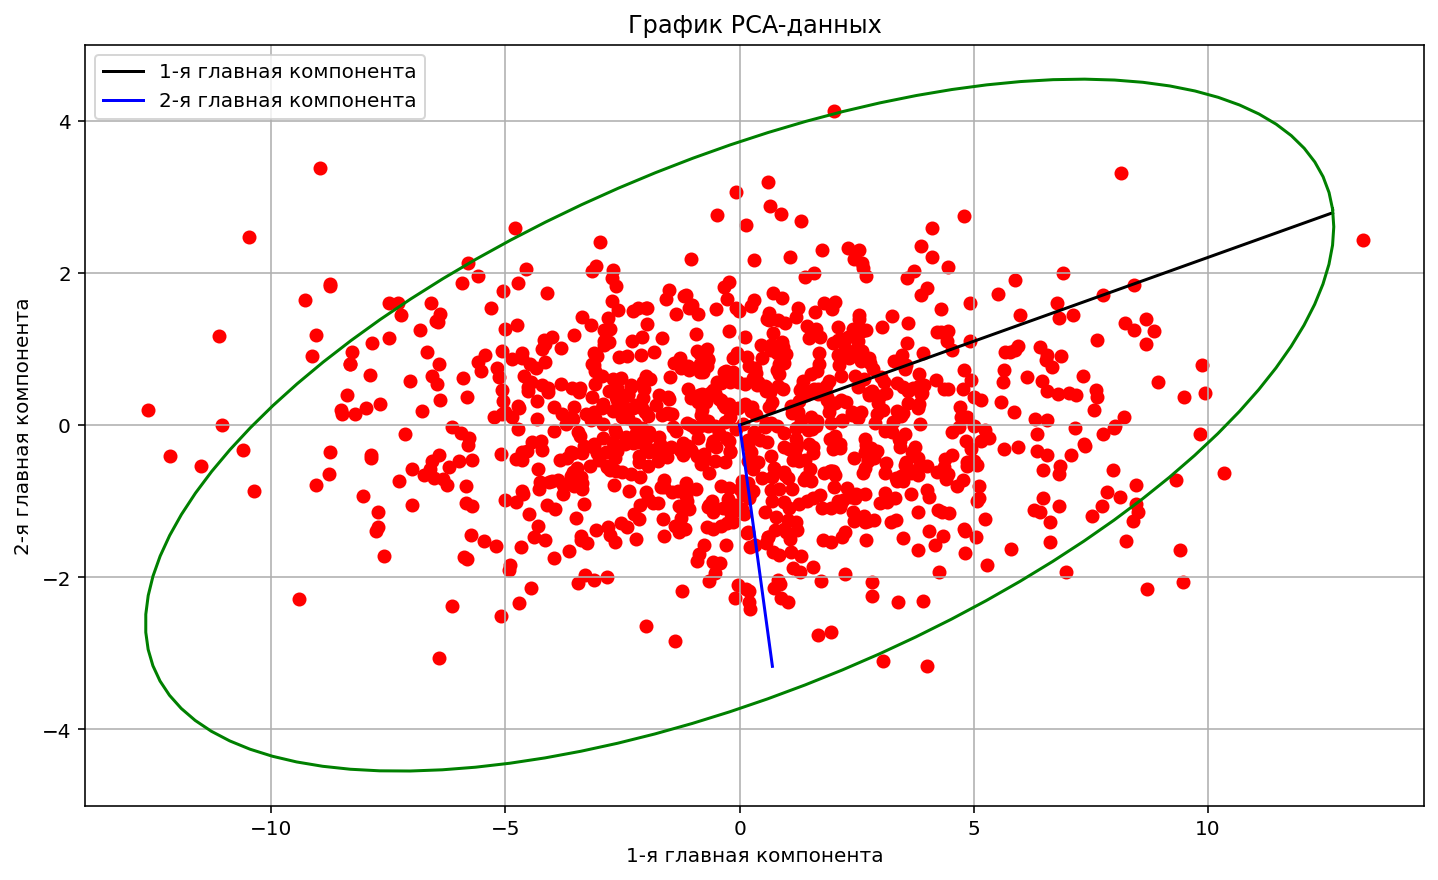

In [3]:
'''
Модельные данные (2 главные компоненты)
'''



'''
Генерация случайной выборки из многомерного нормального распределения
'''
def gen_N(mean, sigma, size):
    return np.random.multivariate_normal(mean=mean, cov=sigma, size=size)



sigma = np.array([
        [1, 2, 3, 4],
        [2, 3, 4, 5],
        [3, 4, 5, 6],
        [4, 5, 6, 7]
    ])
mu = np.array([1, 2, 3, 4])
n = 1000
X = gen_N(mu, sigma, n)
y = np.full((n, 1), 1)
Xy = np.append(X, y, axis = 1)

df = pd.DataFrame(
    data=Xy,
    columns=['1-ый признак', '2-ой признак', '3-ий признак', '4-ый признак', 'Класс'])

analyze(df, data_type='model', n_comps=2)

*** Исходные данные ***


Выборочная матрица ковариаций:
[[2.27932356 2.44676781 2.61421206 2.78165631]
 [2.44676781 3.04387028 3.64097276 4.23807524]
 [2.61421206 3.64097276 4.66773347 5.69449418]
 [2.78165631 4.23807524 5.69449418 7.15091313]]
sum_var = 17.141840438702317


*** Данные после метода PCA ***


Выборочная матрица ковариаций:
[[ 1.59489160e+01  1.00998067e-15  3.07356800e-24]
 [ 1.00998067e-15  1.19292439e+00 -6.88903173e-25]
 [ 3.07356800e-24 -6.88903173e-25  1.17990009e-15]]
sum_var = 17.14184043870231



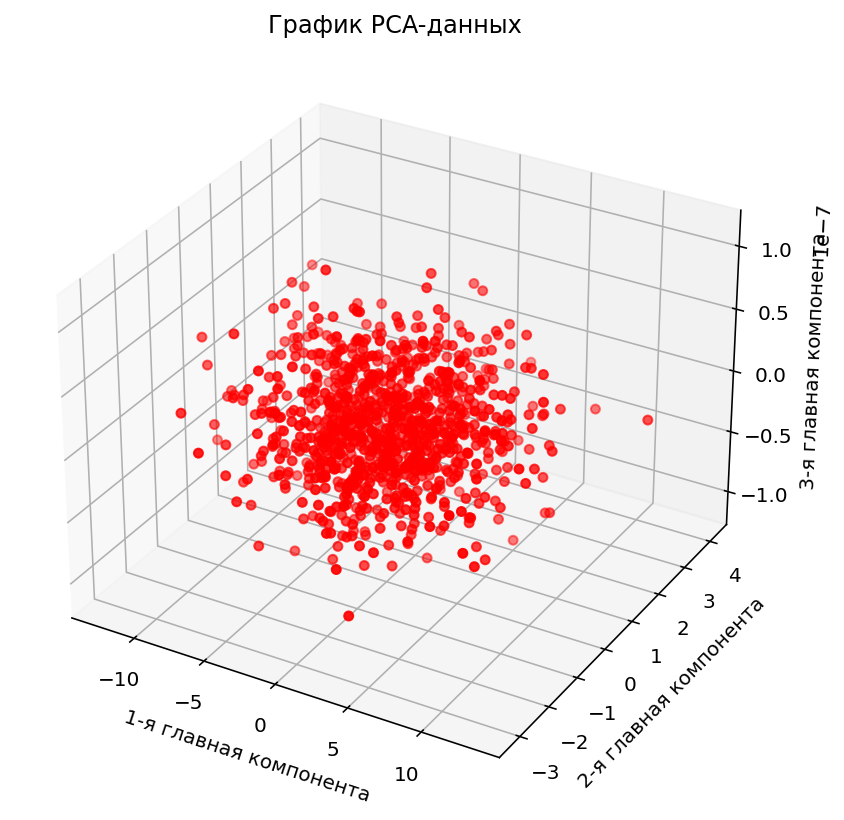

In [4]:
'''
Модельные данные (3 главные компоненты)
'''



analyze(df, data_type='model', n_comps=3)

*** Исходные данные ***


Выборочная матрица ковариаций:
[[ 0.68569351 -0.03926846  1.27368233  0.5169038 ]
 [-0.03926846  0.18800403 -0.32171275 -0.11798121]
 [ 1.27368233 -0.32171275  3.11317942  1.29638747]
 [ 0.5169038  -0.11798121  1.29638747  0.58241432]]
sum_var = 4.569291275167785


*** Данные после метода PCA ***


Выборочная матрица ковариаций:
[[ 4.22484077e+00 -3.65580140e-17 -2.25832938e-17]
 [-3.65580140e-17  2.42243572e-01 -2.09548120e-19]
 [-2.25832938e-17 -2.09548120e-19  7.85239081e-02]]
sum_var = 4.54560824804178



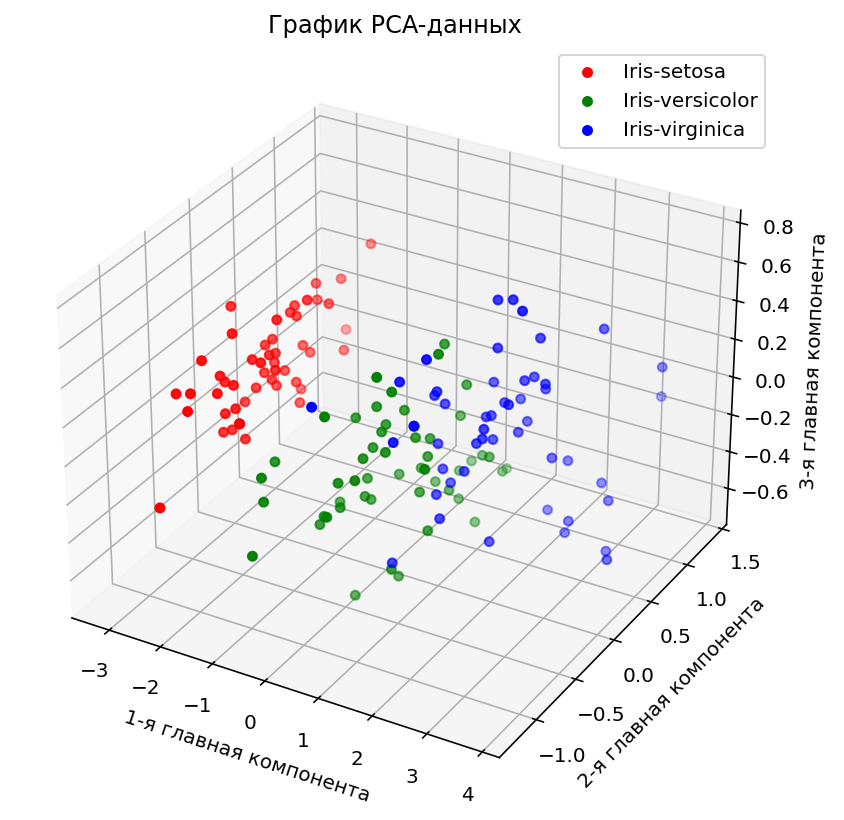

In [5]:
'''
iris
'''



iris_df = pd.read_csv('iris.data',
                      names=[
                          'Длина чашелистика', 'Ширина чашелистика',
                          'Длина лепестка', 'Ширина лепестка', 'Вид'
                      ])
analyze(iris_df, data_type='iris', n_comps=3)

*** Исходные данные ***


Выборочная матрица ковариаций:
[[ 1.58165265e+00 -1.09212312e+00  2.61796797e-01 -1.51876577e+00
   4.42857858e-01  1.61593594e-01  3.85245245e-02 -5.86236236e-02
  -4.26086086e-02  8.54812813e-01  4.15665666e-02  5.52162162e-02
  -6.44144144e-03  4.09329329e-02 -6.35535536e-03 -3.70550551e-02
   2.45935936e-02  4.47057057e-02 -1.26696697e-02 -4.43273273e-02
   7.36726727e-02 -8.70270270e-03 -2.04204204e-02  3.35235235e-02]
 [-1.09212312e+00  1.45415006e+02 -1.00814314e+00  2.12847815e+02
   9.08093093e-01  8.36084084e-01  1.26280280e-01  4.53418418e-01
   3.84957558e+00 -4.95699499e+00 -4.66991992e-01 -7.85995996e-02
  -1.04069069e-01  9.75163163e-01 -3.14725726e-01 -5.61863864e-01
   5.31522523e-01  3.50140140e-02  7.10480480e-02 -2.97934935e-01
  -4.10249249e-01 -7.79439439e-02 -8.74474474e-01  3.20430430e-01]
 [ 2.61796797e-01 -1.00814314e+00  1.17314815e+00 -1.84033534e+00
   6.68418418e-02  1.80900901e-01  3.23423423e-02  7.55505506e-02
  -6.11711712e-02

[0.79426932 0.12054817 0.07462957]


Главных компонент,% объясняемой информации
1,79.426932
2,91.481749
3,98.944705
4,99.195740
5,99.342741
6,99.482677
7,99.582537
8,99.677241
9,99.758069
10,99.805665


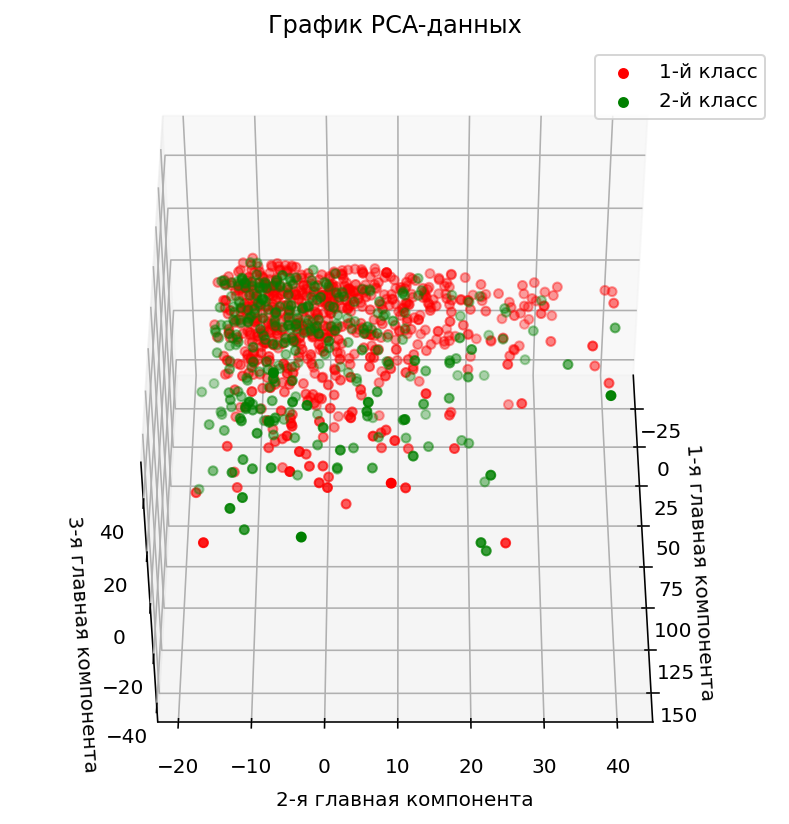

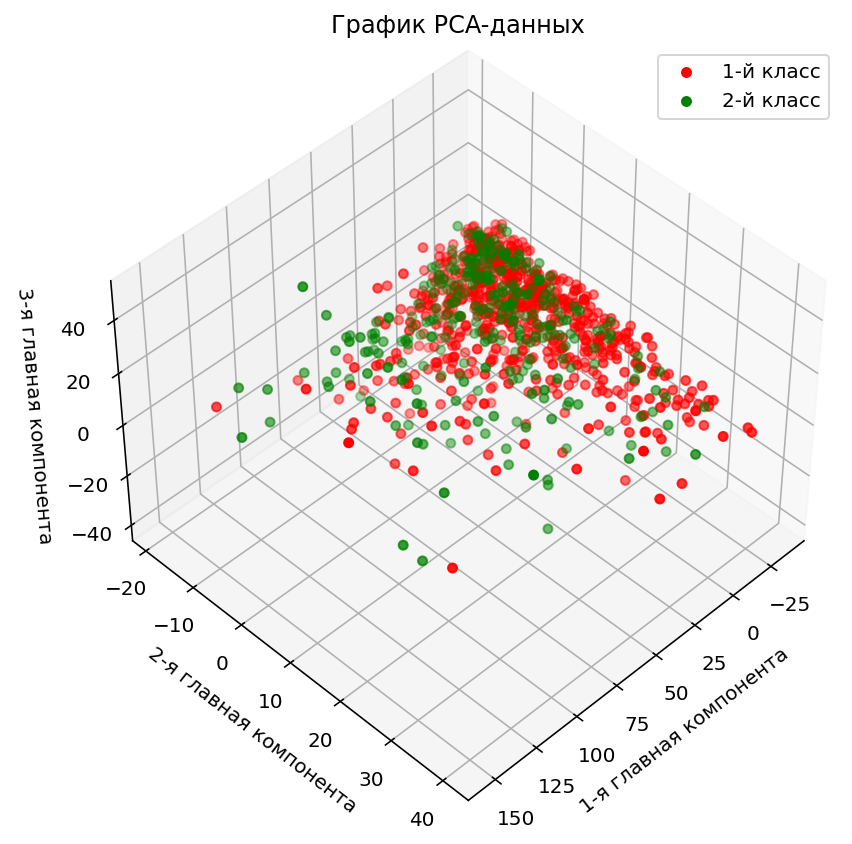

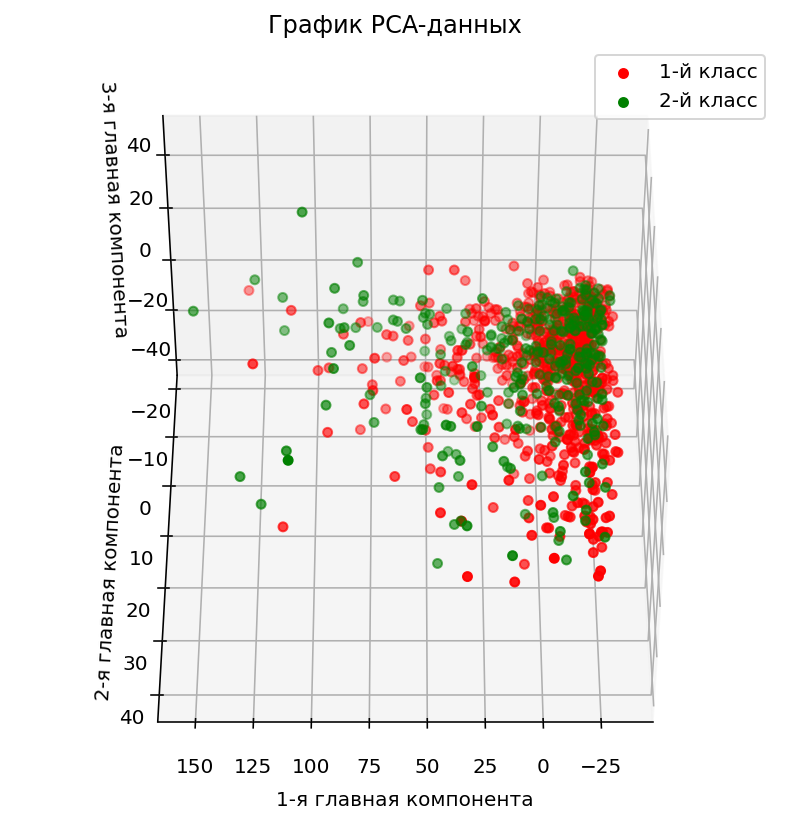

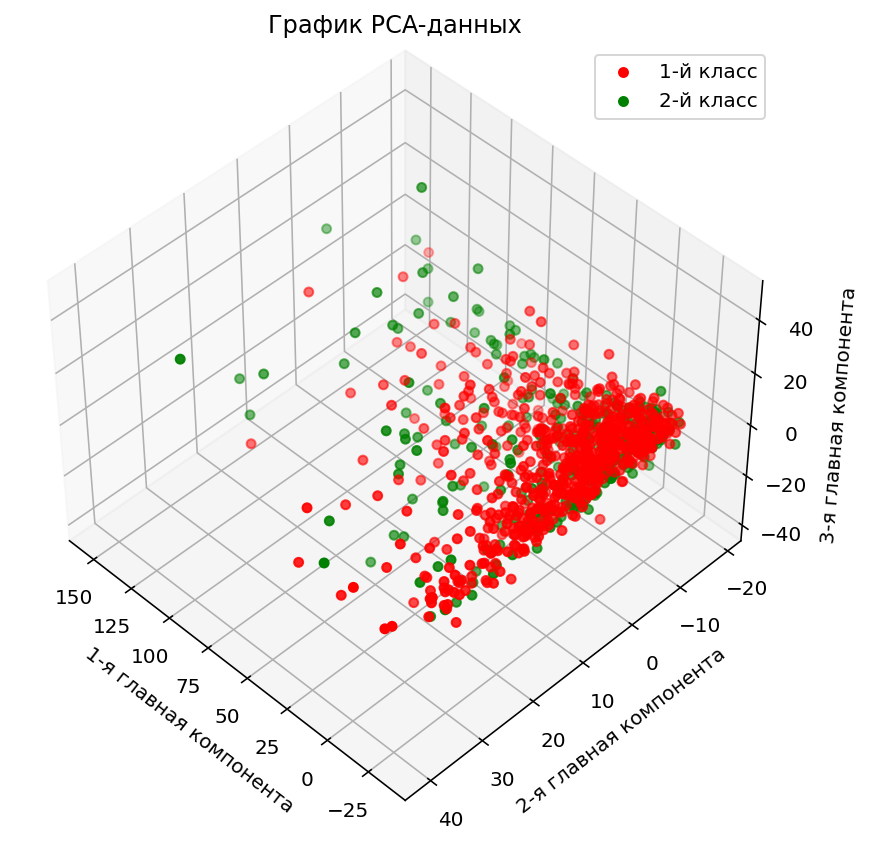

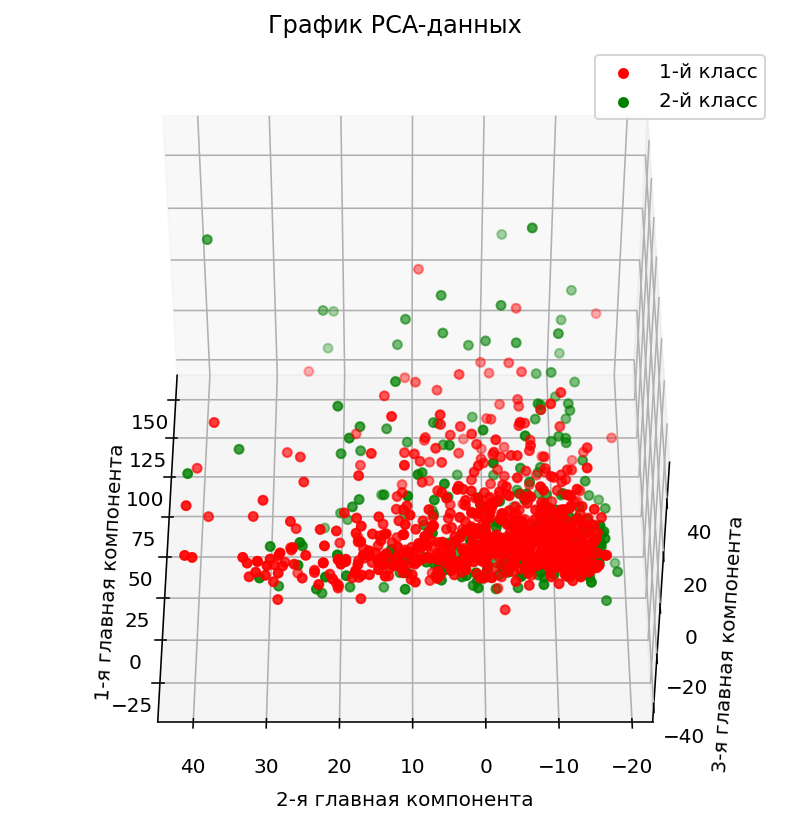

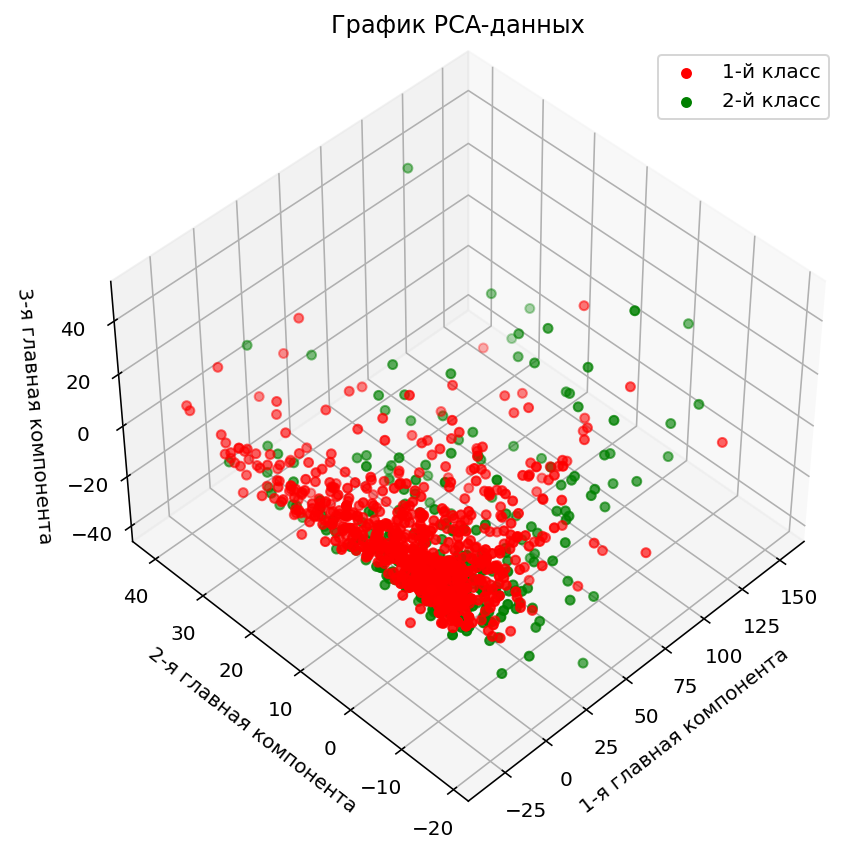

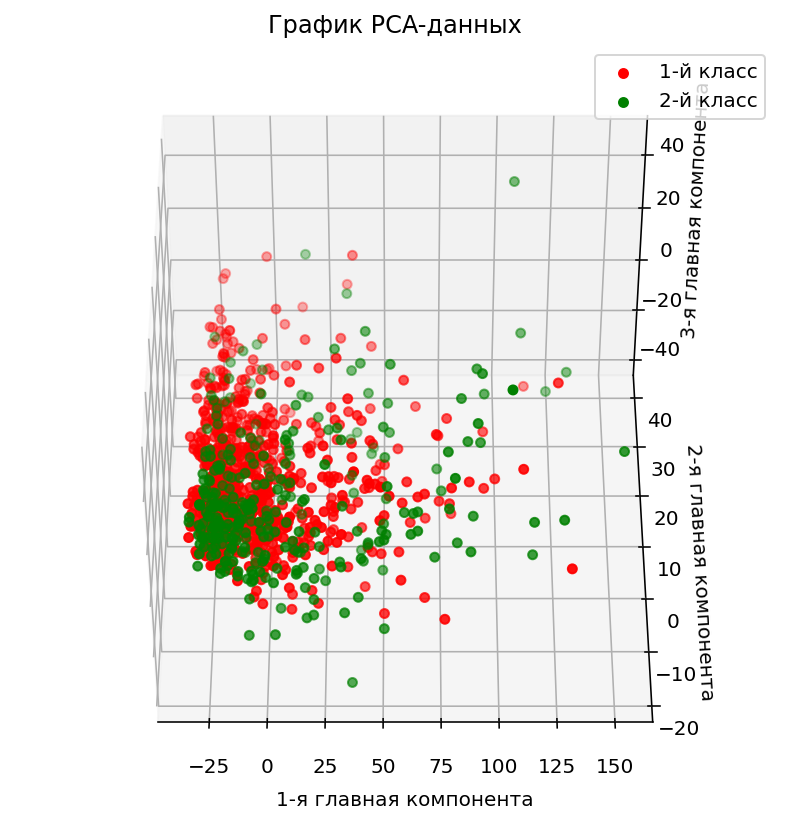

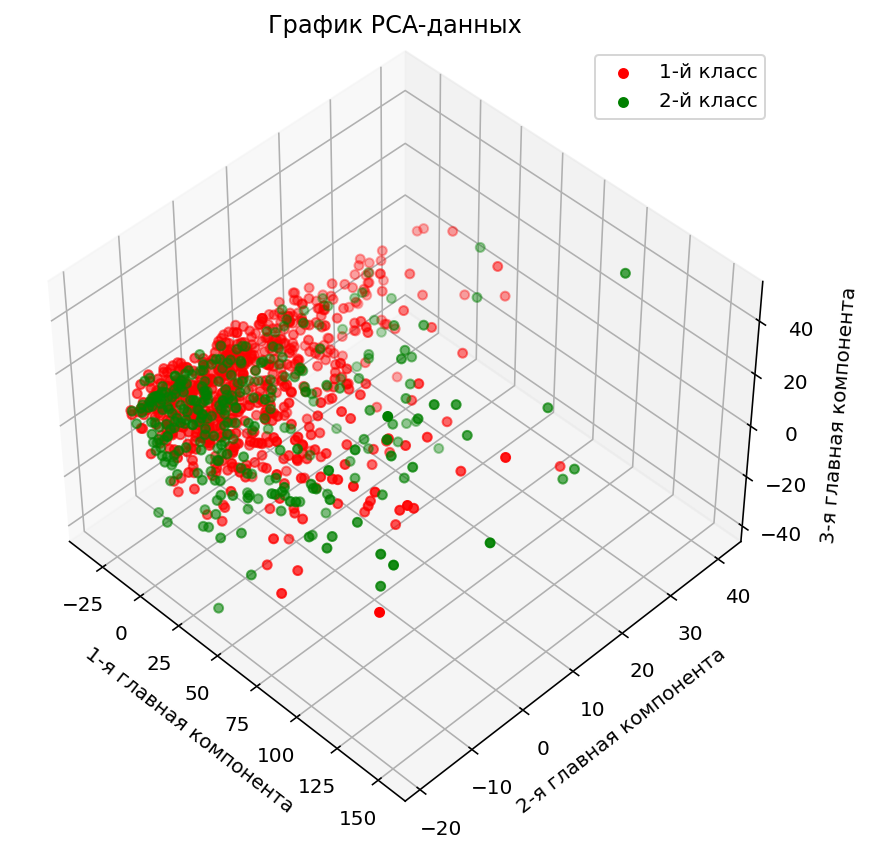

In [6]:
'''
german
'''



'''
Получение и считывание данных из файла в двумерный список int'ов
'''
def parse_file(filename):
    arr = []

    with open(filename) as file:
        for line in file:
            arr.append(list(map(int, line.strip().split())))

    return arr



arr = parse_file('german.data-numeric')
p = len(arr[0]) - 1
columns = [str(i + 1) + '-й признак' for i in range(p)]
columns.append('Класс')

german_df = pd.DataFrame(data=arr, columns=columns)
analyze(german_df, data_type='german', n_comps=3)